# Machine Learning with PyTorch

## Tasks with Networks

<font size="+1">A simple feature classifier</font>
<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">An image classifier</font>
<a href="NetworkExamples_1.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">A regression prediction</font>
<a href="NetworkExamples_2.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Clustering with PyTorch</font>
<a href="NetworkExamples_3.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1"><u><b>Generative Adversarial Networks (GAN)</b></u></font> 
<a href="NetworkExamples_4.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Part of Speech Tagger</font>
<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="right"/></a>

## Generative Adversarial Networks

A GAN (Generative Adversarial Network) is a recent and powerful idea in design of neural networks.  While a GAN is technically a form of unsupervised learning, it cleverly captures much of the power of supervised learning models.  These models seem to have been used most widely in image generation contexts, but there is no reason they cannot be applied equally to other domains.  When applied to images, GAN's often produce "surreal" and sometimes disturbing resemblances to real images.

For example, artist and A.I. enthusiast Robbie Barrat has produced these [images derived from painted nudes](https://twitter.com/DrBeef_/status/978732422085988352/photo/1?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E978732422085988352&ref_url=https%3A%2F%2Fwww.zmescience.com%2Fscience%2Fai-nudes-surreal-185131341%2F):

![GAN Nudes](img/GAN-nudes.png)

Or mentioned in this Martin Giles article in [MIT Technology Review](https://www.technologyreview.com/s/610253/the-ganfather-the-man-whos-given-machines-the-gift-of-imagination/) are these authentic seeming images of "fake celebrities" (computer generated images trained from many images of actual celebrities):

![GAN celebs](img/GAN-celebs.png)

The basic idea in a GAN is to run *two* neural networks in competition—hence the "adversarial" part of the name.  

One neural network is a "generator." Its goal is to generate new data that cannot be distinguished from genuine samples used to develop the GAN.  I.e. we **do** need to start with training datasets, but we do not have any known target feature that identifies correctness.  This is an unsupervised network, but correctness is defined by "belonging to the training set" as opposed to being any other (distribution of) possible values for the features.

The other neural network is the "discriminator." Its goal is to distinguish synthetic samples or observations from genuine ones.  The discriminator engages in a kind of supervised learning, since we the developers *do know* which image is which and can provide feedback to the discriminator.  While supervised models are very powerful, real world data is rarely trying actively to fool them about the class a datum belongs to.  In the GAN model, the adversary is specifically trying to outwit the classifier.

Of course, there are some cases in the real world where fake data tries actively to pass itself off.  In forgery or fraud, a malicious actor is trying to create currency, or artwork, or some other item that can pass inspection by (human or machine) discriminators.  And many kinds of fraud involve trying to create transactions or messages that are difficult to distinguish from legitimate ones.  Unfortunately, GANs will probably be—in fact, probably already are—used to aid in some such fraud.

This O'Reilly Press illustration is a good summary:

![GAN schema](img/gan_schema.png)

### A toy example

For our sample code, we borrow and minimally change a GAN written by Dev Nag in his blog post [Generative Adversarial Networks (GANs) in 50 lines of code (PyTorch)](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f).  Given that it is a toy, designed for simplicity of presentation, all this GAN is trying to learn is a Gaussian random distribution.

In [1]:
from datetime import datetime
from time import time
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
import torch
import torch.nn as nn
import torch.optim as optim
from torch import sigmoid, tanh, relu
%matplotlib inline

# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')

# Check the status of the GPU (if present)
if torch.cuda.is_available():
    torch.cuda.memory_allocated()
    # *MUCH* faster to run on GPU
    device = torch.device('cuda') 
    
print(device)

cuda


### Create the dataset

First thing, initialize the dataset in our mentioned random distribution.  We have a number of choices about what "features" of the data we wish to model.  For this example, we use simply the first four moments of the data, but we could easily use the raw points, or other abstractions of the "shape" of the data, as we wished.

```python
def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - mean_broadcast, exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)
    
# Unused data features (experiment with these on your own).
# Raw data
preprocess, get_num_features = lambda data: data, lambda x: x
# Data and variances
preprocess, get_num_features = lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2
# Data and diffs
preprocess, get_num_features = lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2
```

In [2]:
def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    # excess kurtosis, should be 0 for Gaussian
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  
    final = torch.cat((mean.reshape(1,), std.reshape(1,), 
                       skews.reshape(1,), kurtoses.reshape(1,)))
    return final

# Data points
def d_sampler(n=500, mu=4, sigma=1.25):
    "Provide `n` random Gaussian distributed points with mean `mu` and std `sigma`"
    return torch.Tensor(np.random.normal(mu, sigma, n)).to(device)

def gi_sampler(m=500, n=1):
    "Uniform-dist data into generator, NOT Gaussian"
    return torch.rand(m, n).to(device)

preprocess = get_moments

#### Utility functions

In [3]:
def extract(v):
    return v.data.storage().tolist() 

def stats(v):
    d = extract(v)
    return (np.mean(d), np.std(d), skew(d), kurtosis(d))

#### Visualize a sample from the target distribution

Let us quickly remind ourselves of what we are trying to imitate with the GAN.  This is a sample, and it will look slightly different each time we pull from distribution.  Notice in particular what the mean and spread are, which have to be learned.  For the couple histograms below, we pull 5000 points each from the target distribution and noise distribution to show the underlying "shape" more clearly.  In our actual GAN presented here, we use samples of 500 points from the same distribution, which looks a lot more "stochastic" in its picture, but is a good proxy for something like a photographic image of limited resolution, which are often the inputs to GANs.

Mean: 4.01 | Std: 1.26 | Skew: -0.04 | Kurt: 0.035774
CPU times: user 1.09 s, sys: 602 ms, total: 1.69 s
Wall time: 1.7 s


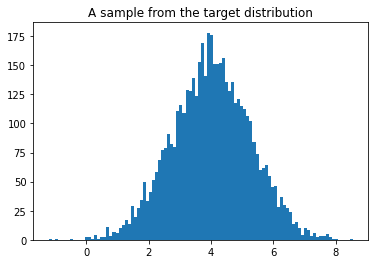

In [4]:
%%time
v = d_sampler(5000)
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu().numpy(), bins=100)
_ = plt.title("A sample from the target distribution")

Mean: 4.00 | Std: 1.26 | Skew: 0.11 | Kurt: -0.070421
CPU times: user 56.2 ms, sys: 8.59 ms, total: 64.8 ms
Wall time: 62.6 ms


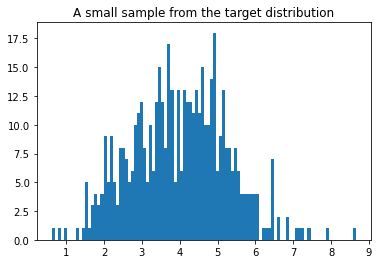

In [5]:
%%time
v = d_sampler()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu().numpy(), bins=100)
_ = plt.title("A small sample from the target distribution")

Mean: 0.50 | Std: 0.29 | Skew: -0.02 | Kurt: -1.201014


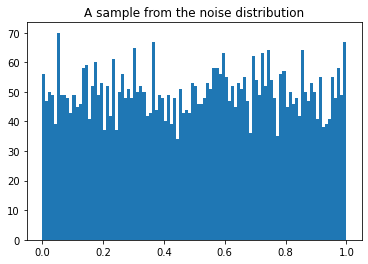

In [6]:
v = gi_sampler(5000).flatten()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu().numpy(), bins=100)
plt.title("A sample from the noise distribution");

Mean: 0.49 | Std: 0.29 | Skew: 0.07 | Kurt: -1.160455


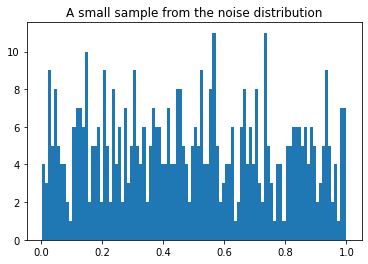

In [7]:
v = gi_sampler().flatten()
print("Mean: %.2f | Std: %.2f | Skew: %.2f | Kurt: %2f" % stats(v))
plt.hist(v.cpu().numpy(), bins=100)
plt.title("A small sample from the noise distribution");

### Define the Models

Define a generator and a discriminator in a standard fashion for PyTorch models.  Both have 3 linear layers.

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super().__init__()
        self.dropout = nn.Dropout(0.25)
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.dropout(x)  # Can we avoid a local trap?
        x = self.f(x)
        x = self.map2(x)
        x = self.dropout(x)  # Can we avoid a local trap?
        x = self.f(x)
        x = self.map3(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super().__init__()
        self.dropout = nn.Dropout(0.25)
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        # dropout layers might make discriminator more robust
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        x = self.f(x)
        return x

### Instantiate models, loss, and optimizer

In [10]:
# Model parameters
G = Generator(input_size=1,   # Random noise dimension, per output vector
              hidden_size=10, # Generator complexity
              output_size=1,  # Size of generated output vector
              f=relu          # Activation function
             ).to(device)

# Use input_size = get_num_features(...) if you try other examples
D = Discriminator(input_size=4,   # 4 moments/features
                  hidden_size=10, # Discriminator complexity
                  output_size=1,  # Single dimension for 'real' vs. 'fake' classification
                  f=sigmoid       # Activation function
                 ).to(device)

# Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
criterion = nn.BCELoss()  

# Stochastic Gradient Descent optimizers
d_learning_rate = 2e-4
g_learning_rate = 2e-4
sgd_momentum = 0.9
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

### Train the model

During training we will show some information and visualization of the progress.

In [11]:
def train(minibatch_size: int=500, 
          g_input_size: int=1, 
          d_input_size: int=5001,
          g_steps: int=20,
          d_steps: int=20,
          num_epochs: int=5001,
          print_interval: int=500,
          fname="img/GAN-%s.png" % datetime.now().isoformat()):

    start = time() 
    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = d_sampler(d_input_size)
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, torch.ones([1]).to(device))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = gi_sampler(minibatch_size, g_input_size)
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, torch.zeros([1]).to(device))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; 
                                   # changes based on stored gradients from backward()

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = gi_sampler(minibatch_size, g_input_size)
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            # Train G to pretend it's genuine
            g_error = criterion(dg_fake_decision, torch.ones([1]).to(device))

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

        if epoch % print_interval == 0:
            rstats, fstats = stats(d_real_data), stats(d_fake_data)
            print("Epoch", epoch, "\n",
                  "Real Dist: Mean: %.2f, Std: %.2f, Skew: %.2f, Kurt: %2f\n" % tuple(rstats),
                  "Fake Dist: Mean: %.2f, Std: %.2f, Skew: %.2f, Kurt: %2f\n" % tuple(fstats),
                  "Time elapsed: %.2f seconds" % (time() - start))
            start = time()
            
            values = extract(g_fake_data)
            plt.hist(values, bins=100)
            plt.xlabel('Value')
            plt.ylabel('Count')
            plt.title('Histogram of Generated Distribution (epoch %d)' % epoch)
            plt.grid(True)
            plt.show()
    
    plt.savefig(fname)

Epoch 0 
 Real Dist: Mean: 4.00, Std: 1.26, Skew: 0.03, Kurt: -0.075985
 Fake Dist: Mean: 0.57, Std: 0.15, Skew: -0.03, Kurt: -0.997747
 Time elapsed: 0.65 seconds


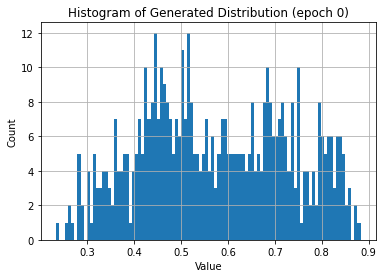

Epoch 500 
 Real Dist: Mean: 4.02, Std: 1.26, Skew: 0.02, Kurt: -0.096819
 Fake Dist: Mean: 6.39, Std: 2.38, Skew: -0.03, Kurt: -0.588473
 Time elapsed: 52.47 seconds


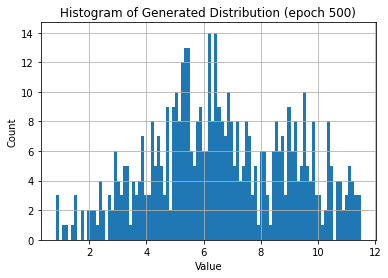

Epoch 1000 
 Real Dist: Mean: 4.01, Std: 1.26, Skew: 0.01, Kurt: -0.052390
 Fake Dist: Mean: 3.66, Std: 0.99, Skew: 0.27, Kurt: -0.430343
 Time elapsed: 52.91 seconds


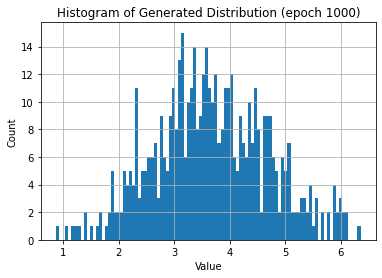

Epoch 1500 
 Real Dist: Mean: 3.98, Std: 1.25, Skew: 0.08, Kurt: -0.069035
 Fake Dist: Mean: 3.86, Std: 1.02, Skew: 0.49, Kurt: 0.331625
 Time elapsed: 52.87 seconds


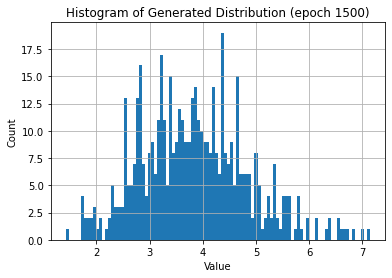

Epoch 2000 
 Real Dist: Mean: 4.00, Std: 1.28, Skew: -0.02, Kurt: -0.086551
 Fake Dist: Mean: 4.03, Std: 1.02, Skew: -0.55, Kurt: -0.361488
 Time elapsed: 52.99 seconds


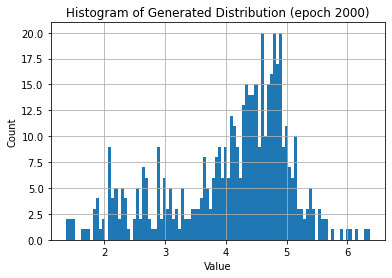

Epoch 2500 
 Real Dist: Mean: 4.01, Std: 1.25, Skew: -0.02, Kurt: -0.115332
 Fake Dist: Mean: 3.89, Std: 1.13, Skew: 0.18, Kurt: 0.921254
 Time elapsed: 53.41 seconds


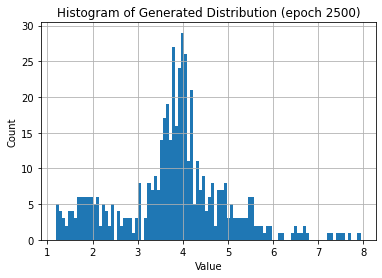

Epoch 3000 
 Real Dist: Mean: 3.98, Std: 1.26, Skew: -0.01, Kurt: -0.039439
 Fake Dist: Mean: 4.50, Std: 1.37, Skew: -0.28, Kurt: 0.790302
 Time elapsed: 53.88 seconds


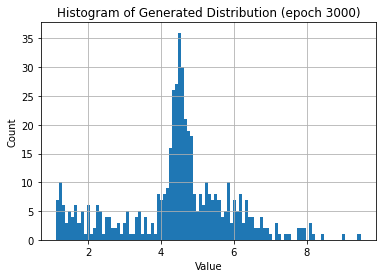

Epoch 3500 
 Real Dist: Mean: 4.00, Std: 1.24, Skew: -0.04, Kurt: -0.079974
 Fake Dist: Mean: 3.91, Std: 1.45, Skew: -0.53, Kurt: 0.329249
 Time elapsed: 53.43 seconds


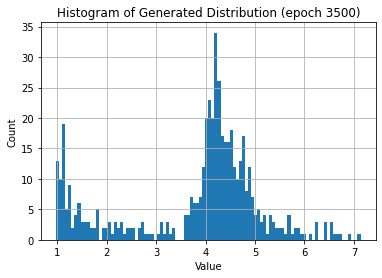

Epoch 4000 
 Real Dist: Mean: 3.99, Std: 1.26, Skew: -0.02, Kurt: -0.033626
 Fake Dist: Mean: 4.31, Std: 1.74, Skew: -0.16, Kurt: 0.176692
 Time elapsed: 52.88 seconds


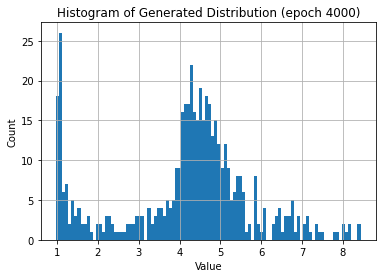

Epoch 4500 
 Real Dist: Mean: 3.99, Std: 1.26, Skew: 0.00, Kurt: -0.051482
 Fake Dist: Mean: 3.75, Std: 1.56, Skew: -0.42, Kurt: -0.910917
 Time elapsed: 53.20 seconds


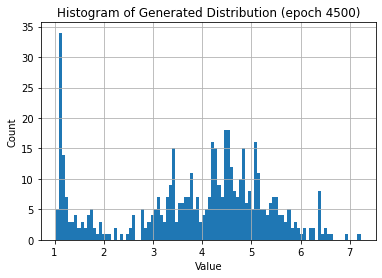

Epoch 5000 
 Real Dist: Mean: 3.98, Std: 1.24, Skew: -0.01, Kurt: -0.028703
 Fake Dist: Mean: 3.87, Std: 1.37, Skew: 0.36, Kurt: 0.141054
 Time elapsed: 53.00 seconds


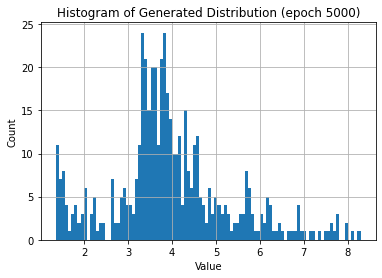

<Figure size 432x288 with 0 Axes>

In [12]:
train()

### Pitfalls and guidelines

When you train the discriminator, the generator will remain contant, and vice versa.  This gives each model a static adversary. If you have a roughly known domain, you might wish to pretrain the discriminator on similar data before starting your training of the generator.  This gives the generator a more difficult adversary to work against.

Depending on the details of the network you configue, as well as other options in their training regimes, learning rates, optimizers, loss functions, and so on, one side of the GAN can overpower the other. If the discriminator is too good, it will return values  close to 0 or 1, and that the generator will be unable to find a meaningful gradient. If the generator is too good, it will exploit weaknesses in the discriminator that lead to false negatives. 

---

Dev Nag, in his blog post that I base this lesson on, present results from multiple runs of and identical GAN, mostly the same at the one in this notebook.  At times it does quite well, but at other times—just depending on randomized initial conditions—it does extremely poorly.  Sometimes additional training rounds may force them out of a poor local maximum, but often an unbalance is reached where progress is not possible.  I am *curious*, and explore it passingly above, whether addition of dropout layers or other layer engineering might mitigate this danger.

![GAN generated distributions](img/GAN-generated-distributions.png)

This final part will run for a long time.  But let us try to replicate successful and failing GANs over a large number epochs, with a large number of trials.

Epoch 0 
 Real Dist: Mean: 4.00, Std: 1.25, Skew: 0.02, Kurt: -0.060707
 Fake Dist: Mean: -0.28, Std: 0.04, Skew: 0.17, Kurt: -0.053391
 Time elapsed: 0.15 seconds


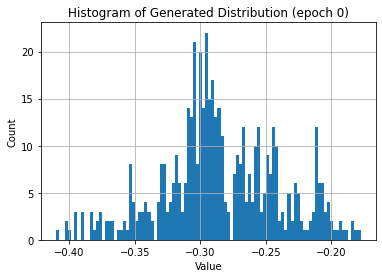

Epoch 5000 
 Real Dist: Mean: 4.01, Std: 1.25, Skew: -0.00, Kurt: -0.103846
 Fake Dist: Mean: 6.90, Std: 2.55, Skew: 0.51, Kurt: 0.920709
 Time elapsed: 526.71 seconds


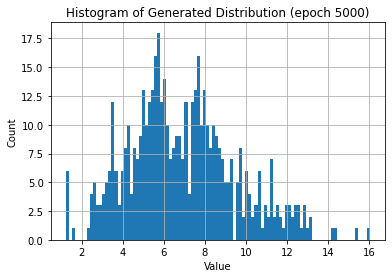

Epoch 10000 
 Real Dist: Mean: 4.03, Std: 1.24, Skew: 0.04, Kurt: -0.101283
 Fake Dist: Mean: 4.00, Std: 1.50, Skew: -0.88, Kurt: -0.275535
 Time elapsed: 521.10 seconds


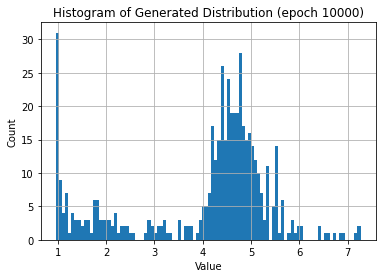

Epoch 0 
 Real Dist: Mean: 4.03, Std: 1.25, Skew: 0.02, Kurt: 0.115549
 Fake Dist: Mean: -0.13, Std: 0.07, Skew: -0.42, Kurt: -0.585653
 Time elapsed: 0.15 seconds


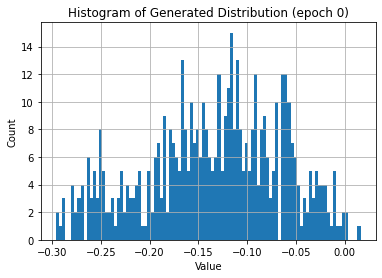

Epoch 5000 
 Real Dist: Mean: 3.99, Std: 1.25, Skew: 0.02, Kurt: 0.035816
 Fake Dist: Mean: 3.74, Std: 0.72, Skew: -1.13, Kurt: 0.889253
 Time elapsed: 519.72 seconds


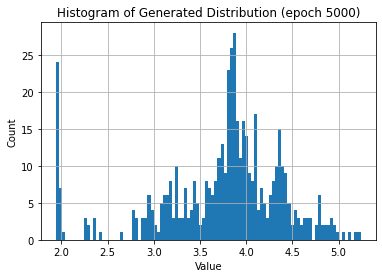

Epoch 10000 
 Real Dist: Mean: 3.99, Std: 1.24, Skew: -0.03, Kurt: -0.030617
 Fake Dist: Mean: 5.94, Std: 2.96, Skew: 0.63, Kurt: -0.165640
 Time elapsed: 515.81 seconds


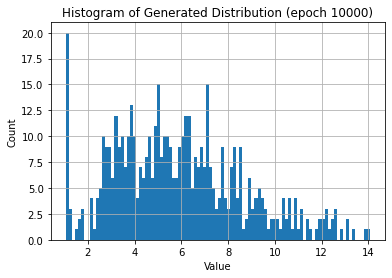

Epoch 0 
 Real Dist: Mean: 4.02, Std: 1.24, Skew: -0.01, Kurt: -0.016446
 Fake Dist: Mean: 0.04, Std: 0.12, Skew: 0.12, Kurt: -0.735736
 Time elapsed: 0.15 seconds


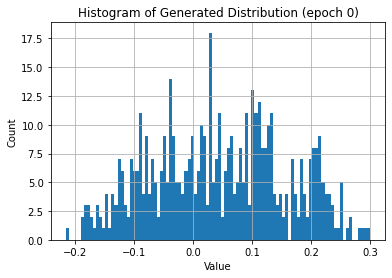

Epoch 5000 
 Real Dist: Mean: 3.99, Std: 1.22, Skew: -0.03, Kurt: -0.002284
 Fake Dist: Mean: 3.12, Std: 0.97, Skew: -0.98, Kurt: -0.448145
 Time elapsed: 521.36 seconds


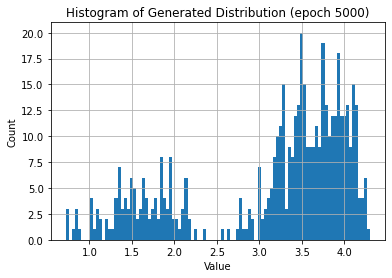

Epoch 10000 
 Real Dist: Mean: 3.99, Std: 1.24, Skew: 0.04, Kurt: 0.052091
 Fake Dist: Mean: 7.06, Std: 3.03, Skew: 0.68, Kurt: -0.178063
 Time elapsed: 522.48 seconds


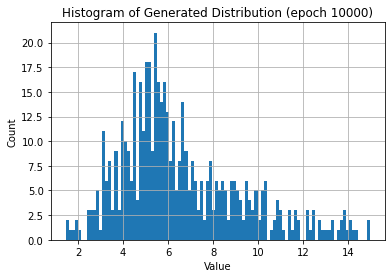

Epoch 0 
 Real Dist: Mean: 4.01, Std: 1.25, Skew: -0.05, Kurt: -0.105944
 Fake Dist: Mean: -0.40, Std: 0.16, Skew: 0.10, Kurt: -0.760660
 Time elapsed: 0.15 seconds


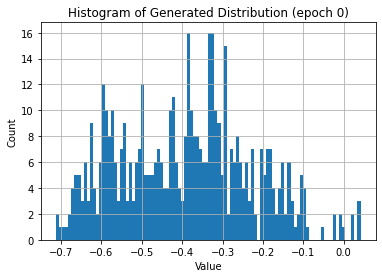

Epoch 5000 
 Real Dist: Mean: 4.01, Std: 1.23, Skew: -0.01, Kurt: -0.100051
 Fake Dist: Mean: 3.86, Std: 1.37, Skew: -0.19, Kurt: -0.018441
 Time elapsed: 526.27 seconds


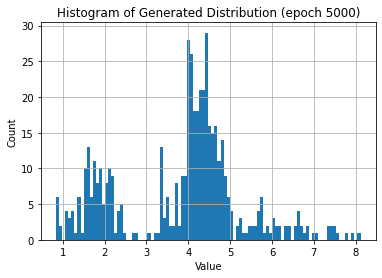

Epoch 10000 
 Real Dist: Mean: 4.00, Std: 1.25, Skew: 0.01, Kurt: -0.006248
 Fake Dist: Mean: 3.76, Std: 1.72, Skew: 0.14, Kurt: -0.281552
 Time elapsed: 524.86 seconds


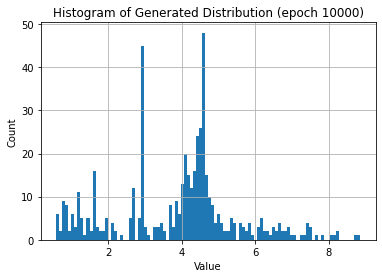

Epoch 0 
 Real Dist: Mean: 3.99, Std: 1.25, Skew: -0.02, Kurt: -0.042100
 Fake Dist: Mean: -0.25, Std: 0.05, Skew: -0.41, Kurt: -0.761536
 Time elapsed: 0.15 seconds


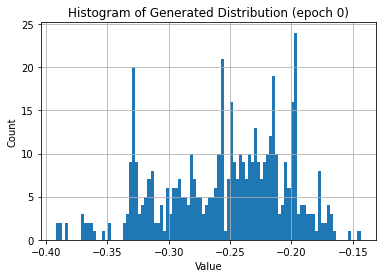

Epoch 5000 
 Real Dist: Mean: 3.97, Std: 1.25, Skew: 0.03, Kurt: -0.117330
 Fake Dist: Mean: 3.76, Std: 1.84, Skew: 0.77, Kurt: -0.263344
 Time elapsed: 517.29 seconds


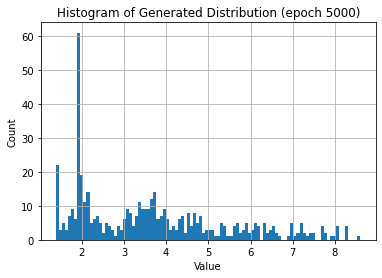

Epoch 10000 
 Real Dist: Mean: 3.99, Std: 1.25, Skew: 0.01, Kurt: -0.014256
 Fake Dist: Mean: 3.96, Std: 1.31, Skew: 0.02, Kurt: 0.057434
 Time elapsed: 525.58 seconds


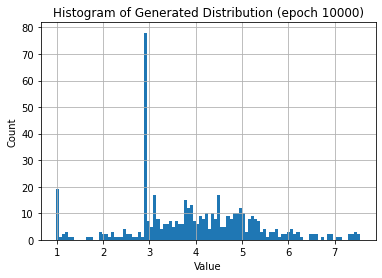

Epoch 0 
 Real Dist: Mean: 4.00, Std: 1.26, Skew: -0.01, Kurt: 0.011606
 Fake Dist: Mean: 0.21, Std: 0.09, Skew: -0.24, Kurt: -0.647048
 Time elapsed: 0.15 seconds


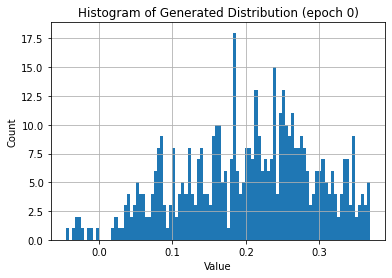

Epoch 5000 
 Real Dist: Mean: 3.98, Std: 1.24, Skew: 0.02, Kurt: -0.119383
 Fake Dist: Mean: 4.28, Std: 0.94, Skew: -0.00, Kurt: -0.046890
 Time elapsed: 517.82 seconds


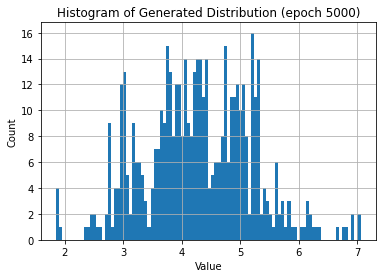

Epoch 10000 
 Real Dist: Mean: 3.97, Std: 1.25, Skew: -0.01, Kurt: 0.032756
 Fake Dist: Mean: 3.45, Std: 1.26, Skew: 0.30, Kurt: -0.119043
 Time elapsed: 528.60 seconds


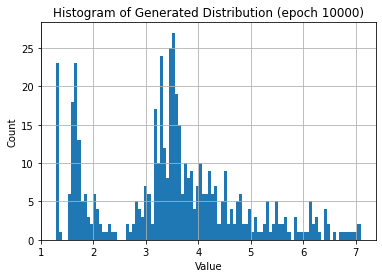

Epoch 0 
 Real Dist: Mean: 4.01, Std: 1.26, Skew: 0.02, Kurt: 0.046263
 Fake Dist: Mean: -0.37, Std: 0.09, Skew: -0.17, Kurt: 0.018970
 Time elapsed: 0.15 seconds


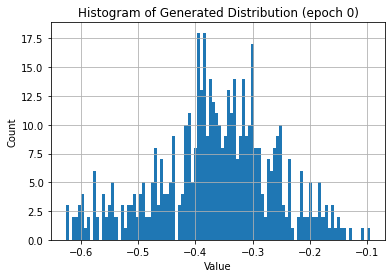

Epoch 5000 
 Real Dist: Mean: 3.95, Std: 1.25, Skew: 0.01, Kurt: -0.052702
 Fake Dist: Mean: 4.22, Std: 0.84, Skew: -0.62, Kurt: -0.348600
 Time elapsed: 523.94 seconds


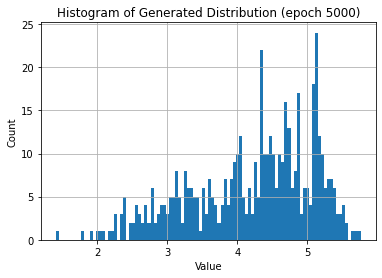

Epoch 10000 
 Real Dist: Mean: 4.02, Std: 1.25, Skew: 0.05, Kurt: 0.122873
 Fake Dist: Mean: 4.31, Std: 1.03, Skew: 0.39, Kurt: -0.044131
 Time elapsed: 516.63 seconds


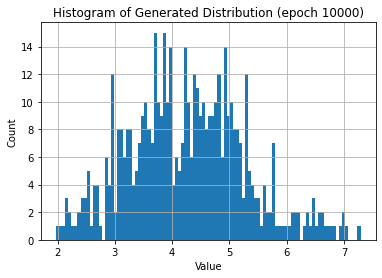

Epoch 0 
 Real Dist: Mean: 4.03, Std: 1.24, Skew: -0.00, Kurt: 0.002110
 Fake Dist: Mean: 0.01, Std: 0.12, Skew: 0.20, Kurt: -0.689494
 Time elapsed: 0.15 seconds


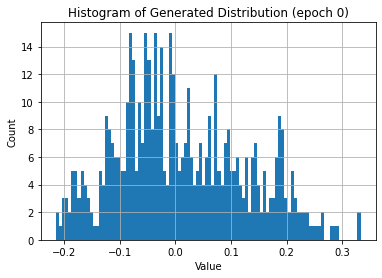

Epoch 5000 
 Real Dist: Mean: 4.01, Std: 1.26, Skew: 0.00, Kurt: 0.077085
 Fake Dist: Mean: 3.96, Std: 1.31, Skew: 0.64, Kurt: 0.320732
 Time elapsed: 526.19 seconds


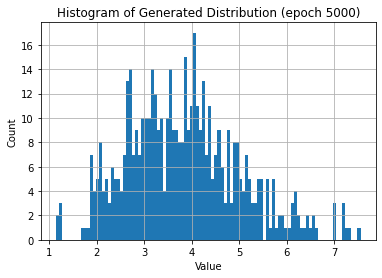

Epoch 10000 
 Real Dist: Mean: 3.99, Std: 1.25, Skew: -0.02, Kurt: -0.008361
 Fake Dist: Mean: 3.97, Std: 1.04, Skew: -0.70, Kurt: -0.559007
 Time elapsed: 521.10 seconds


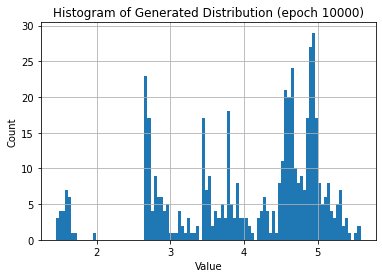

Epoch 0 
 Real Dist: Mean: 4.01, Std: 1.25, Skew: 0.03, Kurt: 0.023278
 Fake Dist: Mean: 0.17, Std: 0.04, Skew: 0.45, Kurt: 0.033449
 Time elapsed: 0.15 seconds


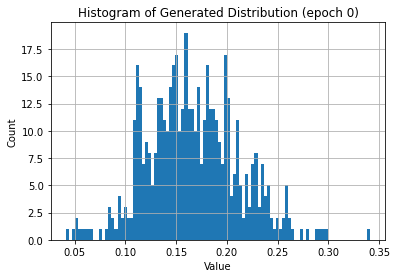

Epoch 5000 
 Real Dist: Mean: 3.98, Std: 1.24, Skew: -0.06, Kurt: 0.104058
 Fake Dist: Mean: 3.83, Std: 1.00, Skew: -0.13, Kurt: -0.597351
 Time elapsed: 529.65 seconds


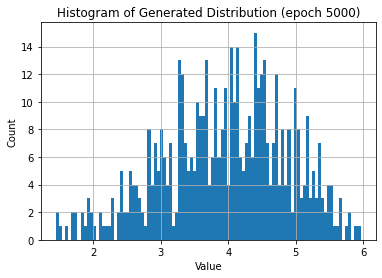

Epoch 10000 
 Real Dist: Mean: 4.00, Std: 1.24, Skew: 0.02, Kurt: 0.025169
 Fake Dist: Mean: 3.89, Std: 1.93, Skew: 0.72, Kurt: -0.162976
 Time elapsed: 518.83 seconds


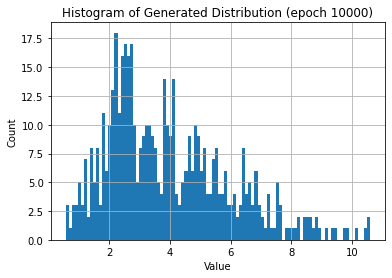

Epoch 0 
 Real Dist: Mean: 4.00, Std: 1.25, Skew: 0.04, Kurt: -0.027858
 Fake Dist: Mean: 0.16, Std: 0.08, Skew: 0.34, Kurt: -0.922925
 Time elapsed: 0.15 seconds


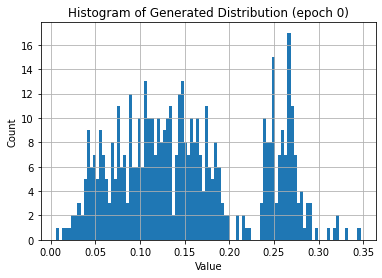

Epoch 5000 
 Real Dist: Mean: 3.98, Std: 1.27, Skew: -0.04, Kurt: 0.069354
 Fake Dist: Mean: 7.07, Std: 2.28, Skew: 0.16, Kurt: -0.535839
 Time elapsed: 516.82 seconds


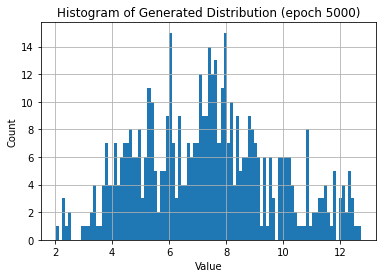

Epoch 10000 
 Real Dist: Mean: 3.98, Std: 1.24, Skew: -0.04, Kurt: 0.023949
 Fake Dist: Mean: 3.83, Std: 1.52, Skew: 0.75, Kurt: 0.385522
 Time elapsed: 520.57 seconds


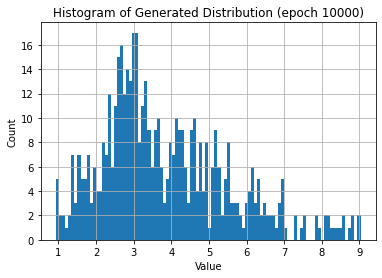

Epoch 0 
 Real Dist: Mean: 4.04, Std: 1.25, Skew: -0.06, Kurt: 0.023773
 Fake Dist: Mean: -0.15, Std: 0.08, Skew: -0.44, Kurt: -0.742964
 Time elapsed: 0.15 seconds


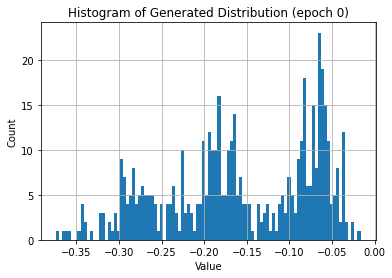

Epoch 5000 
 Real Dist: Mean: 4.03, Std: 1.24, Skew: 0.08, Kurt: -0.103585
 Fake Dist: Mean: 3.58, Std: 1.04, Skew: 0.38, Kurt: 0.046474
 Time elapsed: 526.90 seconds


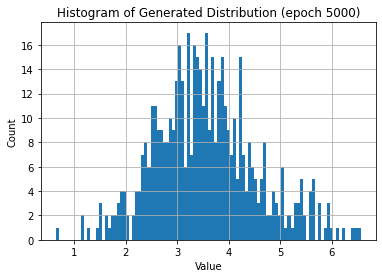

Epoch 10000 
 Real Dist: Mean: 3.97, Std: 1.25, Skew: 0.01, Kurt: -0.045054
 Fake Dist: Mean: 4.72, Std: 1.14, Skew: -1.17, Kurt: 1.271741
 Time elapsed: 535.80 seconds


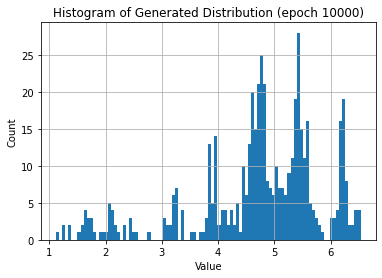

Epoch 0 
 Real Dist: Mean: 3.99, Std: 1.25, Skew: 0.03, Kurt: 0.073680
 Fake Dist: Mean: -0.03, Std: 0.05, Skew: -0.29, Kurt: -0.742097
 Time elapsed: 0.15 seconds


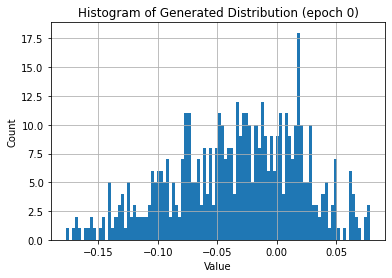

Epoch 5000 
 Real Dist: Mean: 4.00, Std: 1.26, Skew: -0.03, Kurt: -0.096042
 Fake Dist: Mean: 4.57, Std: 1.12, Skew: 0.70, Kurt: 1.027328
 Time elapsed: 528.80 seconds


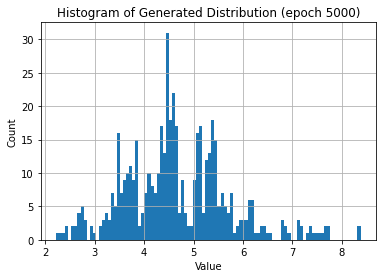

Epoch 10000 
 Real Dist: Mean: 3.99, Std: 1.25, Skew: 0.01, Kurt: -0.059354
 Fake Dist: Mean: 4.09, Std: 0.76, Skew: -0.25, Kurt: 0.038086
 Time elapsed: 523.77 seconds


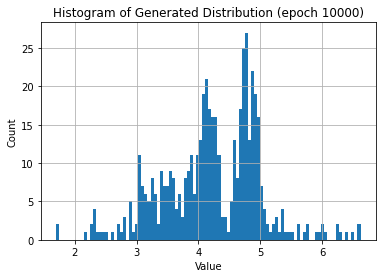

Epoch 0 
 Real Dist: Mean: 3.98, Std: 1.25, Skew: 0.06, Kurt: 0.030806
 Fake Dist: Mean: -0.22, Std: 0.12, Skew: 0.22, Kurt: -0.960889
 Time elapsed: 0.13 seconds


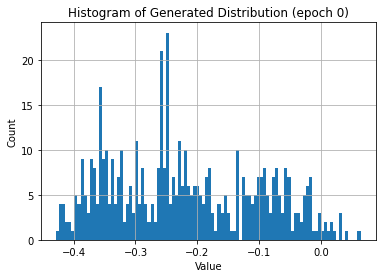

Epoch 5000 
 Real Dist: Mean: 3.99, Std: 1.26, Skew: 0.03, Kurt: 0.163377
 Fake Dist: Mean: 8.11, Std: 3.56, Skew: 0.18, Kurt: -0.767022
 Time elapsed: 523.67 seconds


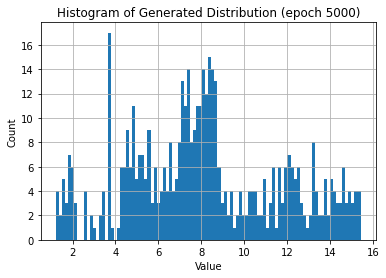

Epoch 10000 
 Real Dist: Mean: 3.99, Std: 1.25, Skew: -0.01, Kurt: 0.057412
 Fake Dist: Mean: 4.29, Std: 0.87, Skew: -0.16, Kurt: -0.286470
 Time elapsed: 522.42 seconds


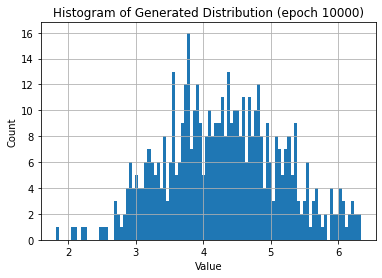

Epoch 0 
 Real Dist: Mean: 4.02, Std: 1.25, Skew: 0.00, Kurt: 0.051030
 Fake Dist: Mean: -0.15, Std: 0.15, Skew: -0.17, Kurt: -0.246318
 Time elapsed: 0.15 seconds


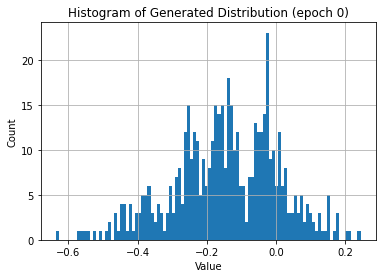

Epoch 5000 
 Real Dist: Mean: 4.01, Std: 1.27, Skew: -0.00, Kurt: 0.039827
 Fake Dist: Mean: 7.97, Std: 3.34, Skew: 0.18, Kurt: -0.596928
 Time elapsed: 532.29 seconds


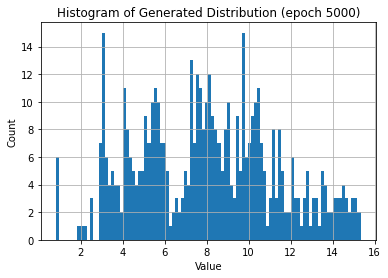

Epoch 10000 
 Real Dist: Mean: 3.98, Std: 1.25, Skew: 0.01, Kurt: -0.053354
 Fake Dist: Mean: 3.56, Std: 1.07, Skew: 0.09, Kurt: -0.708902
 Time elapsed: 526.47 seconds


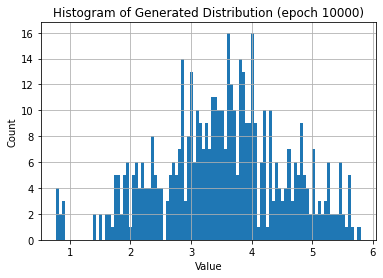

Epoch 0 
 Real Dist: Mean: 4.03, Std: 1.24, Skew: -0.06, Kurt: -0.034429
 Fake Dist: Mean: 0.35, Std: 0.13, Skew: 0.20, Kurt: -0.279400
 Time elapsed: 0.15 seconds


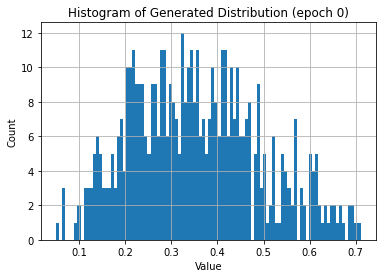

Epoch 5000 
 Real Dist: Mean: 3.99, Std: 1.27, Skew: 0.02, Kurt: 0.059798
 Fake Dist: Mean: 1.98, Std: 0.66, Skew: -0.18, Kurt: -1.170590
 Time elapsed: 515.59 seconds


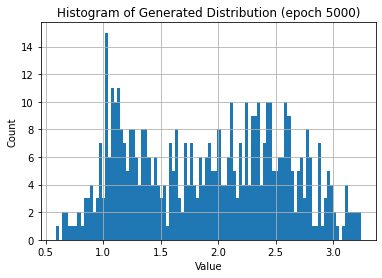

Epoch 10000 
 Real Dist: Mean: 4.02, Std: 1.25, Skew: 0.01, Kurt: 0.095589
 Fake Dist: Mean: 7.26, Std: 3.11, Skew: -0.06, Kurt: -1.150515
 Time elapsed: 522.36 seconds


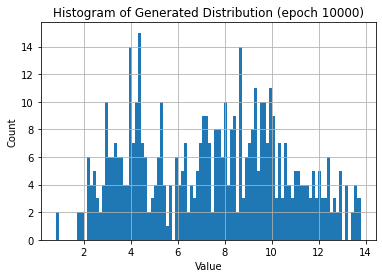

Epoch 0 
 Real Dist: Mean: 4.00, Std: 1.27, Skew: 0.02, Kurt: -0.073919
 Fake Dist: Mean: 0.08, Std: 0.08, Skew: -0.26, Kurt: -0.121307
 Time elapsed: 0.15 seconds


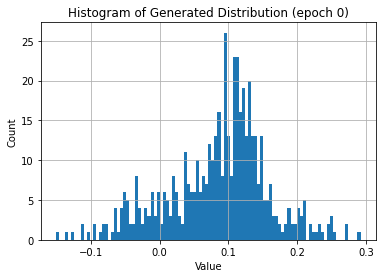

Epoch 5000 
 Real Dist: Mean: 4.02, Std: 1.24, Skew: 0.00, Kurt: 0.072979
 Fake Dist: Mean: 5.93, Std: 2.44, Skew: 0.13, Kurt: -0.664493
 Time elapsed: 524.10 seconds


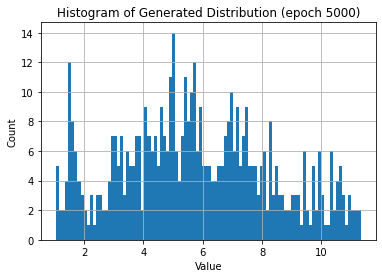

Epoch 10000 
 Real Dist: Mean: 3.99, Std: 1.27, Skew: 0.00, Kurt: -0.122796
 Fake Dist: Mean: 5.27, Std: 1.97, Skew: 0.38, Kurt: -0.337560
 Time elapsed: 529.62 seconds


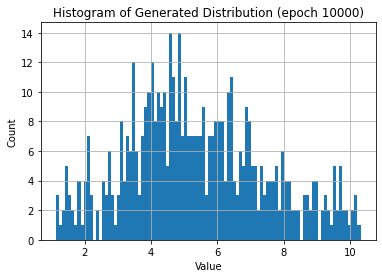

Epoch 0 
 Real Dist: Mean: 4.02, Std: 1.24, Skew: -0.07, Kurt: 0.036947
 Fake Dist: Mean: -0.20, Std: 0.05, Skew: 0.09, Kurt: -0.201336
 Time elapsed: 0.15 seconds


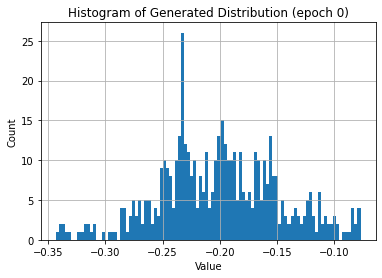

Epoch 5000 
 Real Dist: Mean: 3.98, Std: 1.24, Skew: 0.04, Kurt: -0.020399
 Fake Dist: Mean: -0.06, Std: 0.13, Skew: 0.77, Kurt: -0.091865
 Time elapsed: 519.45 seconds


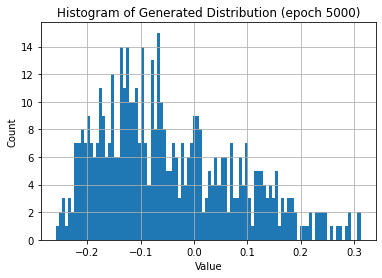

Epoch 10000 
 Real Dist: Mean: 4.02, Std: 1.25, Skew: -0.02, Kurt: -0.012240
 Fake Dist: Mean: 7.23, Std: 3.59, Skew: -0.08, Kurt: -1.020482
 Time elapsed: 525.70 seconds


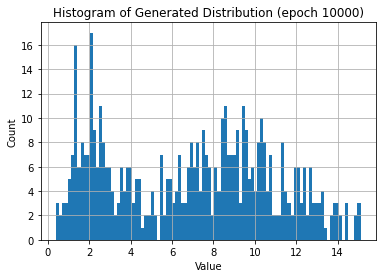

Epoch 0 
 Real Dist: Mean: 4.01, Std: 1.24, Skew: 0.02, Kurt: 0.042811
 Fake Dist: Mean: 0.23, Std: 0.04, Skew: 0.34, Kurt: 0.197323
 Time elapsed: 0.15 seconds


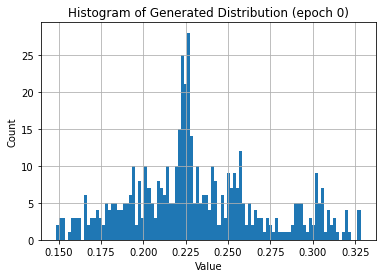

Epoch 5000 
 Real Dist: Mean: 3.98, Std: 1.23, Skew: -0.03, Kurt: -0.089223
 Fake Dist: Mean: 0.44, Std: 0.03, Skew: 1.15, Kurt: 0.324011
 Time elapsed: 528.14 seconds


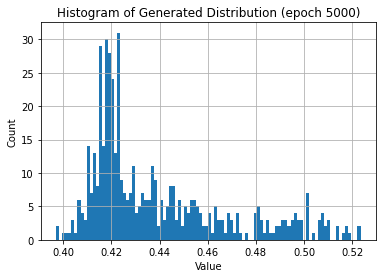

Epoch 10000 
 Real Dist: Mean: 4.00, Std: 1.24, Skew: -0.04, Kurt: -0.188073
 Fake Dist: Mean: 7.13, Std: 2.38, Skew: -0.14, Kurt: -0.602777
 Time elapsed: 534.13 seconds


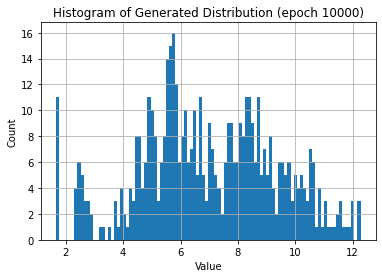

Epoch 0 
 Real Dist: Mean: 4.03, Std: 1.25, Skew: 0.03, Kurt: -0.010383
 Fake Dist: Mean: 0.23, Std: 0.08, Skew: -0.24, Kurt: -0.039888
 Time elapsed: 0.15 seconds


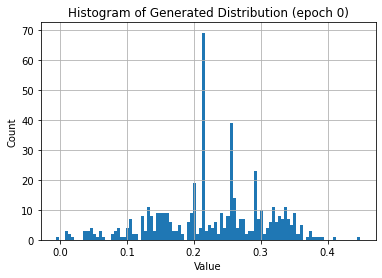

Epoch 5000 
 Real Dist: Mean: 3.98, Std: 1.26, Skew: -0.02, Kurt: 0.029579
 Fake Dist: Mean: 0.38, Std: 0.03, Skew: 0.33, Kurt: -0.769416
 Time elapsed: 524.60 seconds


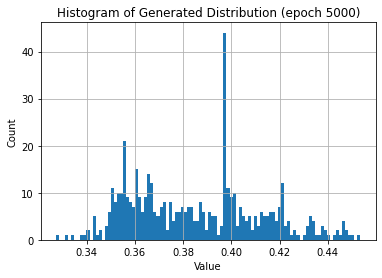

Epoch 10000 
 Real Dist: Mean: 4.03, Std: 1.24, Skew: 0.05, Kurt: -0.078610
 Fake Dist: Mean: 5.33, Std: 1.64, Skew: -0.02, Kurt: -0.675116
 Time elapsed: 521.56 seconds


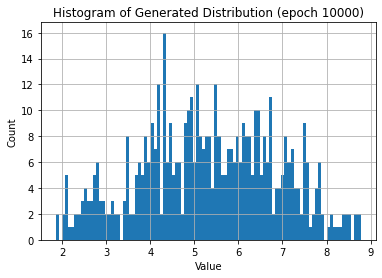

Epoch 0 
 Real Dist: Mean: 3.97, Std: 1.24, Skew: -0.01, Kurt: -0.094752
 Fake Dist: Mean: 0.23, Std: 0.04, Skew: -0.12, Kurt: -0.328976
 Time elapsed: 0.15 seconds


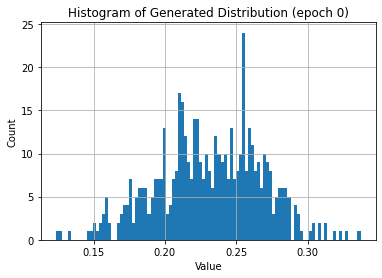

Epoch 5000 
 Real Dist: Mean: 3.97, Std: 1.26, Skew: -0.03, Kurt: -0.058343
 Fake Dist: Mean: 0.38, Std: 0.06, Skew: 0.16, Kurt: -0.801976
 Time elapsed: 516.76 seconds


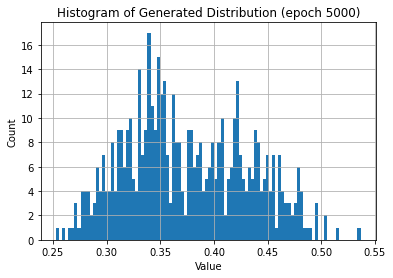

Epoch 10000 
 Real Dist: Mean: 4.00, Std: 1.26, Skew: 0.00, Kurt: 0.085580
 Fake Dist: Mean: 2.57, Std: 0.52, Skew: 0.09, Kurt: -0.506675
 Time elapsed: 523.19 seconds


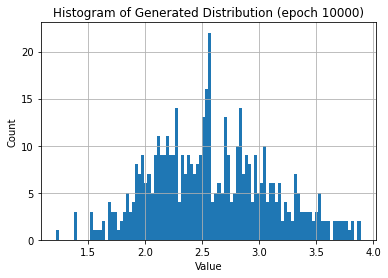

<Figure size 432x288 with 0 Axes>

In [13]:
d_learning_rate = 2e-4
g_learning_rate = 2e-4

for _ in range(20):
    # Generate 100 final images
    torch.cuda.empty_cache() 
    
    # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    criterion = nn.BCELoss()  

    
    
    # Reinitialize generator
    G = Generator(input_size=1,   # Random noise dimension, per output vector
                  hidden_size=10, # Generator complexity
                  output_size=1,  # Size of generated output vector
                  f=relu          # Activation function
                 ).to(device)

    # Reinitialize discriminator
    D = Discriminator(input_size=4,   # 4 moments/features
                      hidden_size=10, # Discriminator complexity
                      output_size=1,  # Single dimension for 'real' vs. 'fake' classification
                      f=sigmoid       # Activation function
                     ).to(device)

    # Stochastic Gradient Descent optimizers
    sgd_momentum = 0.9
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)    
    
    # 10x the default training rounds
    num_epochs = 10_001
    fname = "img/GAN-dlr_%0.6f_glr_%0.6f_epochs_%d.png" % (
                d_learning_rate, g_learning_rate, num_epochs)
    train(num_epochs=num_epochs, 
          print_interval=num_epochs//2, 
          fname=fname)
    
    # Experiment: try different (decreasing) learning rates
    d_learning_rate *= 0.85
    g_learning_rate *= 0.85

## Next Lesson

**Tasks with Networks**: This lesson examined Generative Adversarial Networks. The next lesson will create a part-of-speech tagger.

<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="left"/></a>